# 8-8. 프로젝트 : 인물 모드 문제점 찾기

목차
---
### Step 1. 인물모드 직접 해 보기

### Step 2. 사진에서 문제점 찾기

### Step 3. 해결 방법을 제안해 보기

### 회고

Step 1. 인물모드 직접 해 보기
---

- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

# 1-0. 프로젝트 진행 전 사전 작업

In [1]:
# 필요한 modules import

import cv2
import numpy as np
import os
import tarfile
import urllib # 웹에서 데이터를 다운로드할때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다.

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
    
    print('done')

done


preprocess(): 전처리 함수   
  - 이미지를 적절한 크기로 resize   
  - Chanege: OpenCV default BGR → RGB   
  - 이미지를 input tenser로 변형하여 return  

run(): 세그멘테이션 함수
  - 전처리 된 이미지 run() 함수에서 입력값으로 사용

### 구글에서 제공하는 사전에 학습 된 가중치 (pretrained weight) 불러오기

구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 하고, DeepLabModel 을 초기화합니다.

이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

In [3]:
# deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight 다운로드
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

# DeepLabModel 초기화
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


## 1-1. (배경이 단순한) 사람 이미지 검출

### (1) 사진 준비

In [4]:
# (배경이 단순한) 사람 이미지 로드

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/gown.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print ("이미지 크기 :", img_orig.shape)

이미지 크기 : (1024, 1024, 3)


In [5]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력
# cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다는 것을 명심할 것!!
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max()) #seg_map.max() : 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)

(1024, 1024, 3) (513, 513, 3) 15


위에서 seg_map.max()값이 15가 나왔는데 이 15의 의미는

아래의 LABEL_NAMES를 통해서 15번째인 person인 것을 알 수 있습니다.

In [6]:
# 제공하는 라벨 종류

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### (2) Segmentation으로 사람 분리하기

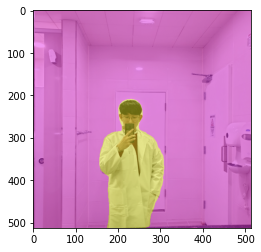

In [7]:
# 사람만 검출해내고 싶기 때문에 사람(person) 라벨, 즉 15를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255 normalization
img_mask = img_mask.astype(np.uint8)
# cv2.applyColorMap - 제공되는 칼라맵을 적용하여 색감을 완전히 변화시킬 수 있음
# 색을 적용하고 이미지를 화면에 출력
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_SPRING) # 기본 COLORMAP_JET은 잘 안보여서 COLORMAP_SPRING으로 바꿈
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사람을 뜻하는 15 외 예측은 0으로 만들었습니다. 그럼 예측된 세그멘테이션 이미지(map)는 최댓값이 15가 됩니다. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력합니다.

### (3) Segmentation 결과를 원래 크기로 복원

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력 시, 출력도 resize 된 입력 크기와 같게 나옵니다.

그러므로, 위에서 나온 세그멘테이션 결과(mask)를 원래 크기로 복원을 진행합니다.

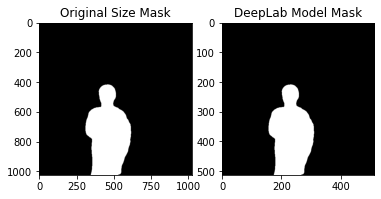

In [8]:
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # 크기를 키울 때 보간(interpolation) 을 고려
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
# img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻는데 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법임

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

원본과 DeepLab Model 간의 x,y 좌표가 다른 것을 통해 resize가 되고 되지 않고를 알 수 있습니다.

### (4) 배경 흐리게 하기

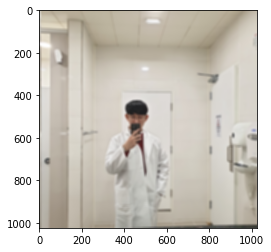

In [9]:
# blur()함수를 이용해서 배경을 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

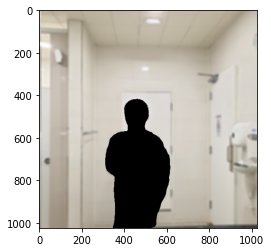

In [10]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- bitwise_not : not 연산하여 이미지 반전

- bitwise_and : 배경과 and 연산하여 배경만 있는 이미지를 얻을 수 있습니다.

### (5) 흐린 배경과 원본 영상 합성

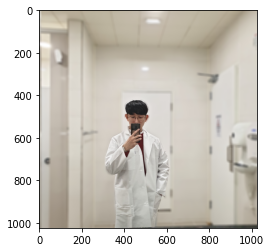

In [11]:
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

배경이 단순한 사진이어서 그런지, 원본 사진과 흐린 배경이 합성이 된 듯 하지만, 화질 상의 문제인지 본인의 모습이 흐릿해 보이는 경향이 보입니다.

## 1-2. (배경이 복잡한) 사람 이미지 검출

### (1) 사진 준비

In [12]:
# (배경이 복잡한) 사람 이미지 로드

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cheese.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print ("이미지 크기 :", img_orig.shape)

이미지 크기 : (1024, 1024, 3)


### (2) Segmentation으로 사람 분리하기

(1024, 1024, 3) (513, 513, 3) 15


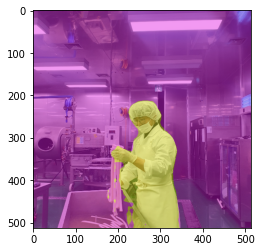

In [13]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# cv2는 채널을 HWC 순서로 표시

# Segmentation으로 사람 분리하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255 normalization
img_mask = img_mask.astype(np.uint8)
# cv2.applyColorMap - 제공되는 칼라맵을 적용하여 색감을 완전히 변화시킬 수 있음
# 색을 적용하고 이미지를 화면에 출력
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_SPRING) # 기본 COLORMAP_JET은 잘 안보여서 COLORMAP_SPRING으로 바꿈
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### (3) Segmentation 결과를 원래 크기로 복원

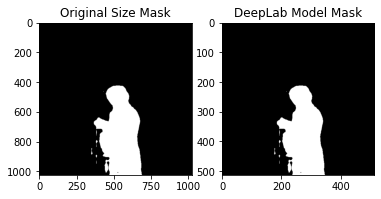

In [14]:
# 이미지 사이즈 비교
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### (4) 배경 흐리게 하기

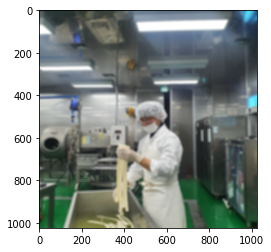

In [15]:
# blur()함수를 이용해서 배경을 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻함 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

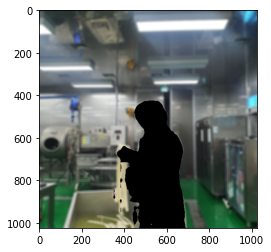

In [16]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### (5) 흐린 배경과 원본 영상 합성

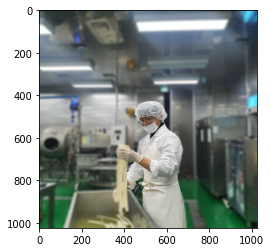

In [17]:
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

배경이 복잡하고, 사람 외의 사물이 신체에 가까이 있기는 하였지만, 흐려진 이미지에서 세그멘테이션 마스크를 보면 나름대로 분별을 해서 검출을 하였음을 확인 할 수 있었습니다.

## 1-3. (배경이 복잡하고 몸이 돌아간) 사람 이미지 검출

### (1) 사진 준비

In [18]:
# (배경이 복잡하고 몸이 돌아간) 사람 이미지 로드

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/pipette.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path)
print ("이미지 크기 :", img_orig.shape)

이미지 크기 : (1024, 1024, 3)


### (2) Segmentation으로 사람 분리하기

(1024, 1024, 3) (513, 513, 3) 20


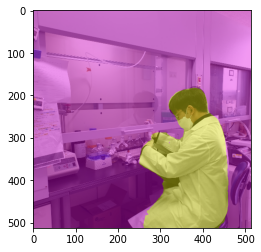

In [19]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# cv2는 채널을 HWC 순서로 표시

# Segmentation으로 사람 분리하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255 normalization
img_mask = img_mask.astype(np.uint8)
# cv2.applyColorMap - 제공되는 칼라맵을 적용하여 색감을 완전히 변화시킬 수 있음
# 색을 적용하고 이미지를 화면에 출력
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_SPRING) # 기본 COLORMAP_JET은 잘 안보여서 COLORMAP_SPRING으로 바꿈
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### (3) Segmentation 결과를 원래 크기로 복원

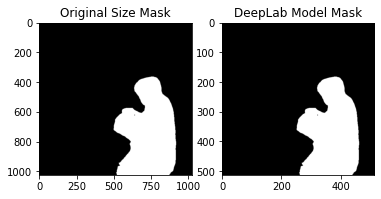

In [20]:
# 이미지 사이즈 비교
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### (4) 배경 흐리게 하기

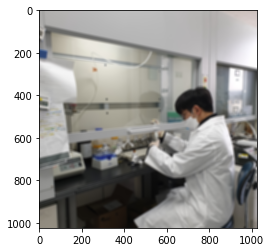

In [21]:
# blur()함수를 이용해서 배경을 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻함 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

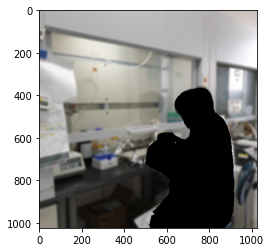

In [22]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### (5) 흐린 배경과 원본 영상 합성

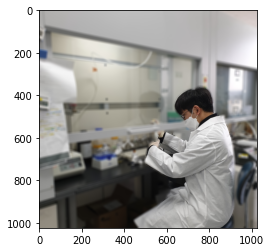

In [23]:
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

복잡한 배경이기도 하고 몸이 조금 돌아가 있기는 하지만, 왼쪽 하단에 있는 가운의 일부와 오른 쪽 피셋을 잡은 손을 인식하지 못한 것을 제외하고는 세그멘테이션이 잘 되었음을 확인 할 수 있었습니다.

## 1-4. 고양이 이미지 검출

### (1) 사진 준비

In [24]:
# 고양이 이미지 로드

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path)
print ("이미지 크기 :", img_orig.shape)

이미지 크기 : (364, 550, 3)


### (2) Segmentation으로 고양이 분리하기

(364, 550, 3) (339, 513, 3) 8


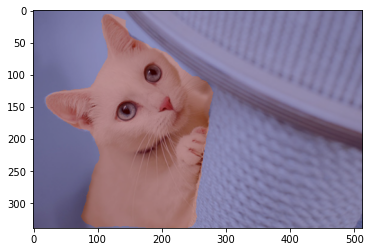

In [25]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# cv2는 채널을 HWC 순서로 표시

# Segmentation으로 고양이 분리하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
# 예측 중 고양이만 추출 cat의 label은 8

img_mask = seg_map * (255/seg_map.max())
# 255 normalization(이미지 정규화)

img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### (3) Segmentation 결과를 원래 크기로 복원

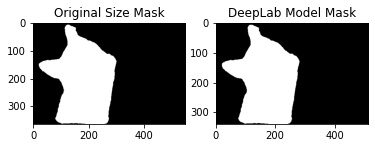

In [26]:
# 이미지 사이즈 비교
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### (4) 배경 흐리게 하기

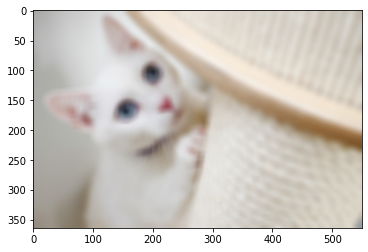

In [27]:
# blur()함수를 이용해서 배경을 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻함 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

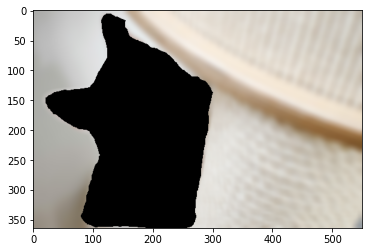

In [29]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### (5) 흐린 배경과 원본 영상 합성

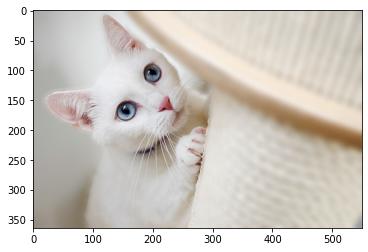

In [30]:
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

고양이의 세그멘테이션과 블러처리가 위에서 진행한 사진 보다 잘 진행 되었음을 확인 할 수 있었습니다.

## 1-5. 배경 합성 하기

### (1) 사진 준비

이미지 크기 : (450, 800, 3)


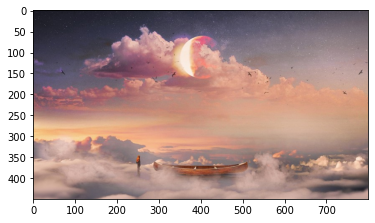

In [31]:
# 배경 이미지 불러오기
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Galaxy.jpeg'  # 본인이 사용할 사진의 경로
bg_img_orig = cv2.imread(bg_img_path)
print("이미지 크기 :" , bg_img_orig.shape)

bg_img_rgb = cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(bg_img_rgb)
plt.show()

(364, 550, 3)


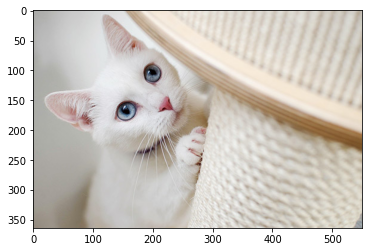

In [32]:
# 고양이 이미지 불러오기
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'  # 본인이 사용할 사진의 경로
cat_img_orig = cv2.imread(cat_img_path)
print(cat_img_orig.shape)

cat_img_rgb = cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(cat_img_rgb)
plt.show()

### (2) 배경 이미지 사이즈 변경

In [33]:
# 배경 이미지와 고양이 이미지 크기 맞추기
target_size = (cat_img_orig.shape[1], cat_img_orig.shape[0])
bg_resized = cv2.resize(bg_img_orig, target_size)  # 배경 이미지를 target size 크기로 resize 합니다.

### (3) 배경 이미지에 고양이 사진 합성

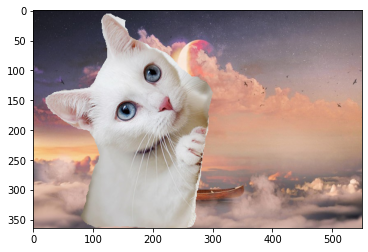

In [34]:
# 배경과 원본 이미지 합성하기
# 앞에서 segementation 작업을 통해 이미 만들어둔 고양이 사진에 수영장 이미지를 합성합니다.

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat3 = np.where(img_mask_color==255, cat_img_orig, bg_resized)

plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

Step 2. 사진에서 문제점 찾기
---
그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

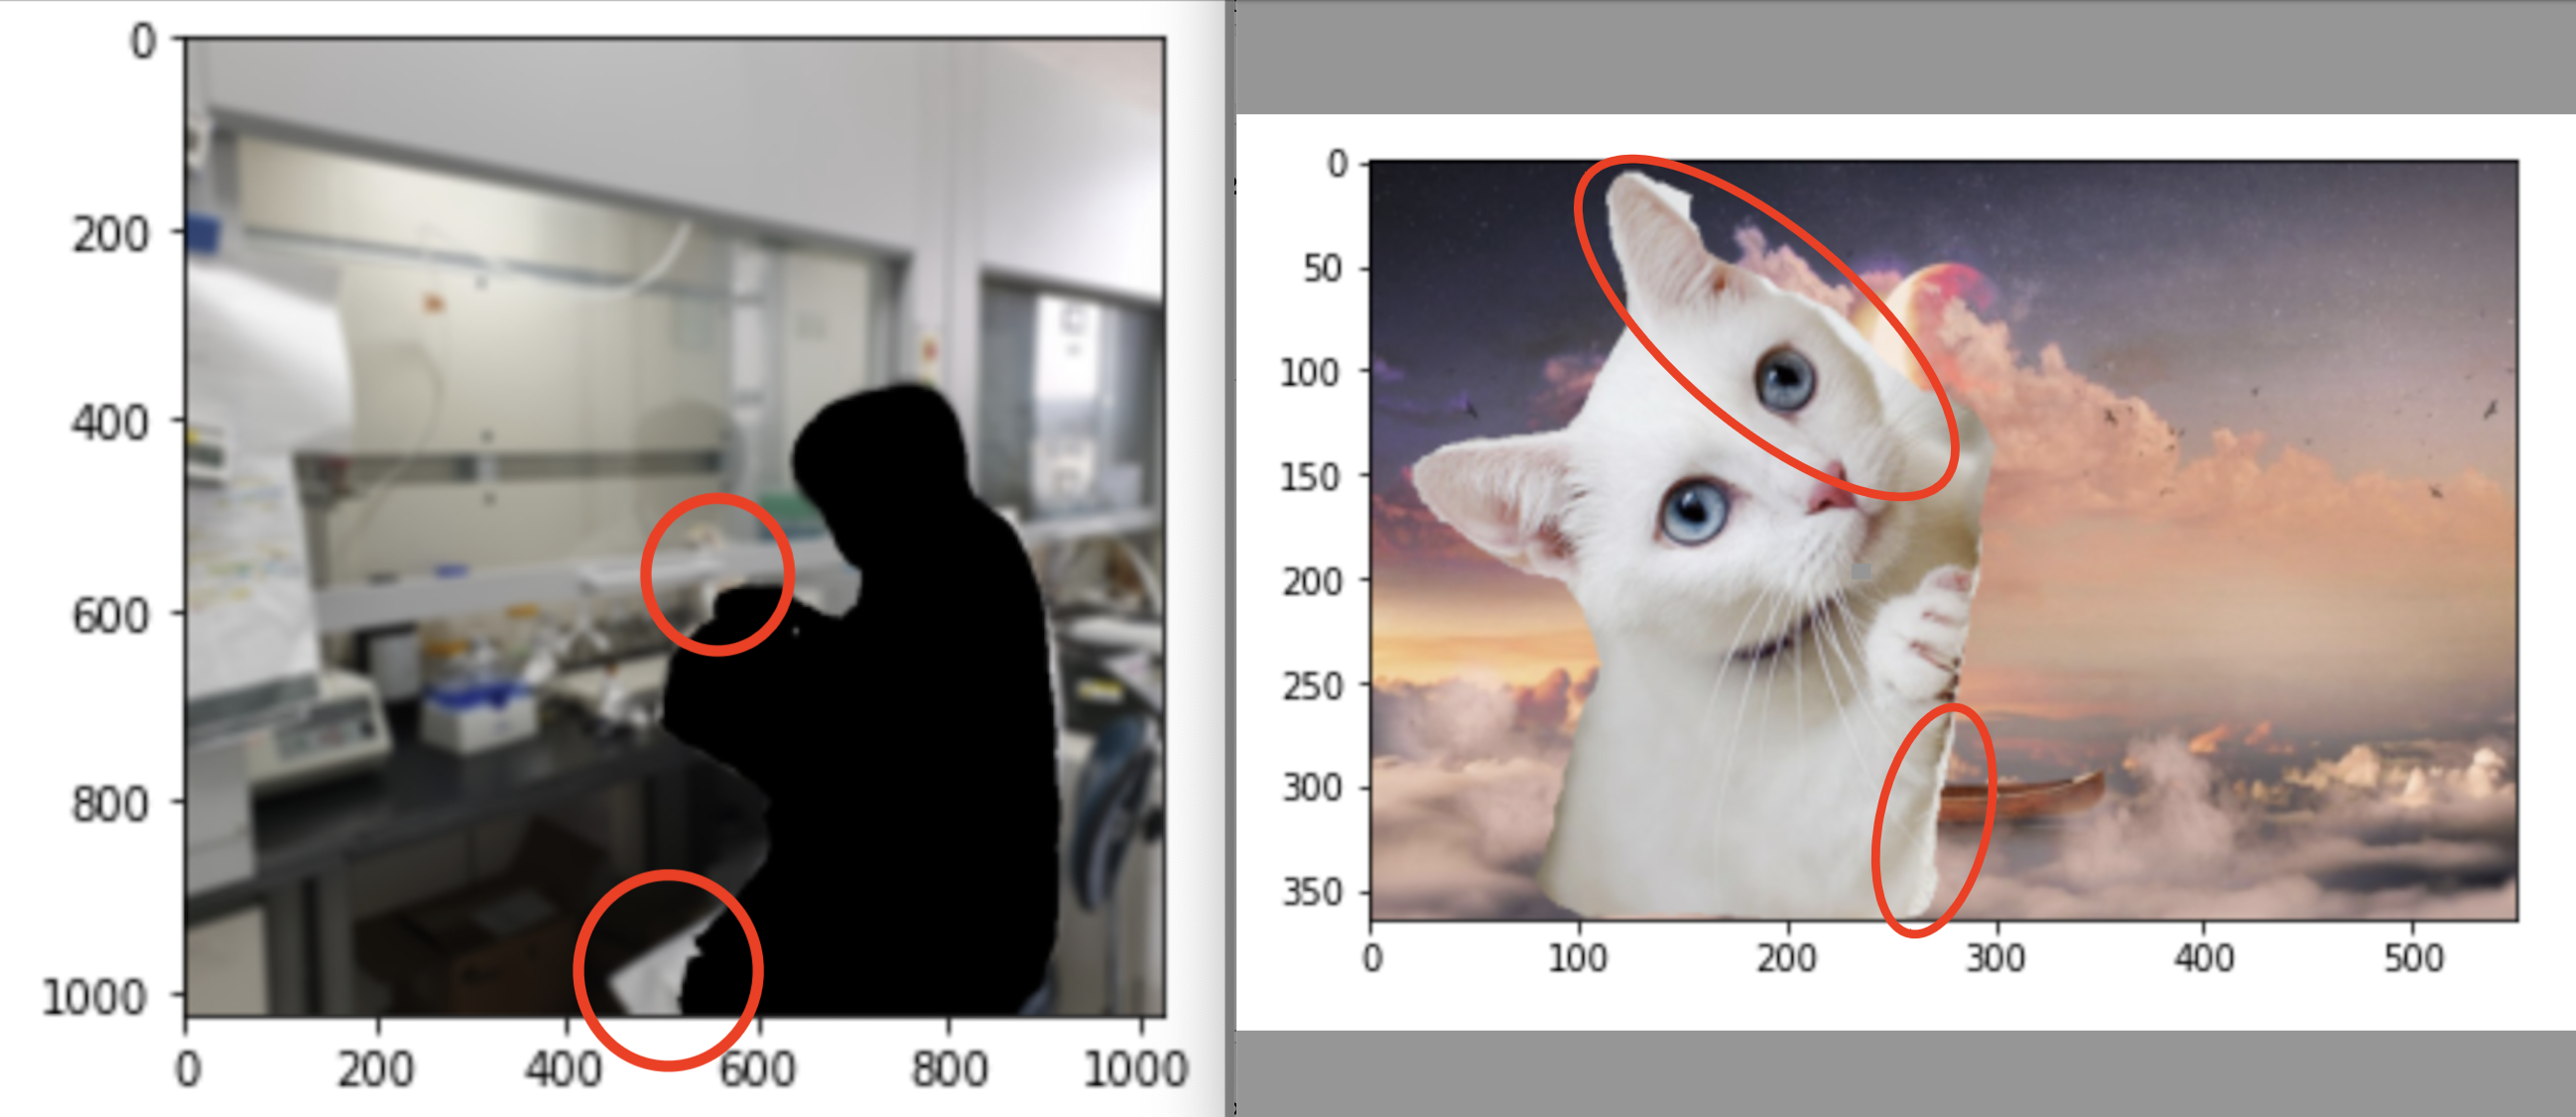

왼쪽 사진에선 가운의 좌측 하단과 피펫을 잡고 있는 오른손이 정확하게 segmentation 되지 못 했고,

우측 사진에선, 고양이의 우측 얼굴 부분과 앞발 영역의 segmentation이 되지 않았고, 추가적으로 배경과 적합한 위치에 합성이 되지 않는 문제가 발생 되었습니다.

Step 3. 해결 방법을 제안해 보기
---
아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

### 세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

### 피사계 심도 이해하기
우선 피사계심도의 개념부터 명확히 이해해 봅시다.

### 3D Depth Camera 활용하기
카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 요즘 스마트폰의 카메라는 렌즈가 2개 달려있지요? 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해 봅시다.

### 깊이 영상(Depth image) 활용하기
하지만 꼭 카메라가 2개여야 할까요? 아래 이미지는 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 있는 이미지입니다. 아래 이미지의 세 번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능함을 보여줍니다.

### IR(적외선)을 활용한 사례
구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.

- uDepth: Real-time 3D Depth Sensing on the Pixel 4

엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!

## 솔루션
---

솔지히, 프로젝트 가이드에서 세그멘테이션의 한계, 피사계 심도 이해하기, 3D Depth Camera 활용, Depth image 활용, IR 을 활용한 사례 등 다양한 사례를 제공해 주셔서, 거기에 대한 정보를 알아보기는 하였으나 어떻게 적용을 해야할 지에 대해서는 의문이 들었습니다.

그래서 우수 노드를 보며, 활용할 수 있는 예시를 알아보는 시간을 가지기는 하였지만, 솔직히 제가 내용을 숙지하고 적용하는 것에 대한 능력이 부족해서 그런지 이해하는 과정에서 어려움을 느껴서 참고 레퍼런스 (https://github.com/ysmNew/Aiffel/blob/main/Ex08/Segmentation.ipynb)를 기록 하는 것으로 대체 하겠습니다.

평가문항
---

1. 인물모드 사진을 성공적으로 제작하였다.

- 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.

- 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.

- 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

## 회고
---

개인적으로 이번 노드를 공부하면서, 제가 평소에 가지고 다니던 카메라를 사용하면서 생활화 된 개념들을

코딩으로 구현 및 정의를 보며 제가 아는 것을 조금 더 딥하게 알아보고, 체화하는 시간이 되었다고 생각합니다.

Segmentation에 대한 개념 숙지 및 Semantic segmetntaion과 Instance segmentation의 차이를 확실하게 이해할 수 있었다고 생각합니다.

다만, 이번 프로젝트는 해커톤과 기간이 겹쳐서 프로젝트에 시간 투자를 많이 못 해서, 위에서의 문제들을 해결하지 못한 것에 대한 아쉬움이 있습니다.

물론, 프로젝트에서 필요로 하는 바를 다 이루지는 못하였으나, 프로젝트에서 달성해야 하는 평가요소들을 채우기 위해 노력을 하며, 의미 있는 시간을 보냈다고 생각합니다.

지금은 저의 실력으로 프로젝트를 완수하지 못하였으나, 언젠가 이번 프로젝트를 다시 돌아와 수정해보도록 해보겠습니다.